# Vegetation Phenology

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a),
[crop_mask](https://explorer.digitalearth.africa/products/crop_mask)

## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects).

## Matt's suggestions

- Start a fresh notebook
- Use the shapefile and geopandas parts above to makea geopandas Dataframe of points, and cooresponding polygon
- Start a dask LocalCluster
- Datacube load for the bounds of the polygon = `data`
- for each point in the geopandas dataframe,
   - get the timeseries for the point from `data`, e.g. using `data.sel(latitude=lat, longitude=lon)`. See https://docs.xarray.dev/en/stable/user-guide/indexing.html
   - plot or do something with each timeseries

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os, sys
from datetime import datetime


import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils.rio import configure_s3_access
from datacube.utils.geometry import Geometry
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool   # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from mpl_toolkits.axes_grid1 import host_subplot

repo1 = '/home/jovyan/easi-notebooks'
if repo1 not in sys.path: sys.path.append(repo1)

os.environ['USE_PYGEOS'] = '0'
from easi_tools import EasiDefaults, notebook_utils
easi = EasiDefaults()

repo = '/home/jovyan/deafrica-sandbox-notebooks/Tools'
if repo not in sys.path: sys.path.append(repo)

from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology

Successfully found configuration for deployment "asia"


In [83]:
import rioxarray as rio
import seaborn as sns

## Dask computing environment

In EASI, each notebook starts by defining a Dask cluster for the notebook to use.

> For more information regarding Dask, see [A2 - Dask](A2%20-%20Dask.ipynb).

The are two main methods for setting up your dask cluster: 
1. **Local dask cluster**
    - Provides a dask multiprocessing environment on your Jupyter node. Useful for processing data volumes that don't exceed the Jupyter node limits, which are currently set at `cores = 8, memory = 32 GB` (2x large)


1. **Dask Gateway**
    - Provides a scalable compute cluster in EASI for your use. You can (*should*) use the same cluster across each of your notebooks (a separate cluster per notebook would unnessarily use EASI resources).
    - For most notebooks and data analysis start with `2 to 4 workers` (adaptive). Dask gateway is limited to 20 workers per user.
    - It is normal for this step to take **3 to 5 minutes** if new computing nodes need to be generated

**This notebook will just use a local cluster**

### Dask cluster

For local cluster options, see https://docs.dask.org/en/latest/setup/single-distributed.html

The Dask Dashboard link shown after the following cell is a helpful resource to explore the activity and state of your dask cluster.

In [2]:
# cluster, client = notebook_utils.initialize_dask(use_gateway=False)
# display(cluster if cluster else client)
# print(notebook_utils.localcluster_dashboard(client, server=easi.hub))

# Use EASI 'dask gateway' cluster
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,5))
display(client)

Starting new cluster.


<Client: 'tls://10.0.63.77:8786' processes=0 threads=0, memory=0 B>

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Vegetation_phenology")
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`.
* `lat`: The central latitude to analyse (e.g. `24.35`).
* `lon`: The central longitude to analyse (e.g. `88.4`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2022-10', '2023-04')`).

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 24.35`, `lon = 88.4`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the EASI by draging and dropping files to the Jupyter Notebook File Browser (left side) . ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [5]:
# Set the vegetation proxy to use
veg_proxy = "NDVI"
time_range = ("2022-10-01", "2023-04-30")

In [6]:
# Method 2: Use a polygon as a GeoJSON or Esri Shapefile.
gdf = gpd.read_file('/home/jovyan/EASI_Bangladesh/input_data/lentil_22-23.shp') #/home/jovyan/input_data/lentil_22-23.shp
geopolygon_gdf = gpd.GeoDataFrame(geometry=[gdf.unary_union.convex_hull], crs=gdf.crs)

# Get the latitude and longitude range of the geopolygon
buffer = 0.001  # approximate 100 m
lat_range = (geopolygon_gdf.total_bounds[1]-buffer, geopolygon_gdf.total_bounds[3]+buffer)
lon_range = (geopolygon_gdf.total_bounds[0]-buffer, geopolygon_gdf.total_bounds[2]+buffer)

In [7]:
lat_range, lon_range

((24.3862745, 24.4360797), (88.3965147, 88.47943120000001))

In [8]:
display(geopolygon_gdf)
display(gdf)

geometry
0  POLYGON ((88.46732 24.38727, 88.44501 24.39276...

start   latitude  longitude  Yield(t/ha                   geometry
0    2023-02-28  24.425337  88.413161    0.898200  POINT (88.41316 24.42534)
1    2023-02-28  24.425380  88.412949    0.898200  POINT (88.41295 24.42538)
2    2023-03-05  24.408209  88.463824    0.898200  POINT (88.46382 24.40821)
3    2023-03-05  24.408758  88.463470    0.748500  POINT (88.46347 24.40876)
4    2023-03-05  24.408059  88.462607    1.047900  POINT (88.46261 24.40806)
..          ...        ...        ...         ...                        ...
198  2023-04-27  24.410867  88.424580    1.085325  POINT (88.42458 24.41087)
199  2023-04-27  24.410865  88.424590    0.935625  POINT (88.42459 24.41087)
200  2023-04-27  24.410040  88.424343    0.973050  POINT (88.42434 24.41004)
201  2023-04-27  24.409848  88.424048    0.860775  POINT (88.42405 24.40985)
202  2023-04-27  24.409549  88.424274    0.935625  POINT (88.42427 24.40955)

[203 rows x 5 columns]

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [9]:
display_map(x=lon_range, y=lat_range)

# Load dataset

In [9]:
# Uses the older (collection 0) S2 L2A

# from easi_tools.load_s2l2a import load_s2l2a_with_offset

# query = dict(
#     product = 's2_l2a',
#     x = lon_range,
#     y = lat_range,
#     time = time_range
# )
# output_crs = notebook_utils.mostcommon_crs(dc, query)
# load_params = dict(
#     output_crs = output_crs,
#     resolution = (-10, 10),
#     dask_chunks = {'x':2048, 'y':2048},
#     group_by = 'solar_day'
# )
# ds = load_s2l2a_with_offset(
#     dc,
#     query | load_params   # Combine the two dicts that contain our search and load parameters
# )
# display(data)
# notebook_utils.xarray_object_size(data)

In [10]:
# Uses the new Collection 1 L2A
query = dict(
    product = 'sentinel_2_c1_l2a',
    x = lon_range,
    y = lat_range,
    time = time_range
)
output_crs = notebook_utils.mostcommon_crs(dc, query)
load_params = dict(
    output_crs = output_crs,
    resolution = (-10, 10),
    dask_chunks = {'x':2048, 'y':2048},
    group_by = 'solar_day',
    skip_broken_datasets = True,
)
data = dc.load(**(query | load_params))
display(notebook_utils.xarray_object_size(data))

'Dataset size: 407.88 MB'

In [11]:
data

<xarray.Dataset>
Dimensions:      (time: 29, y: 561, x: 848)
Coordinates:
  * time         (time) datetime64[ns] 2022-12-10T04:51:42.497000 ... 2023-04...
  * y            (y) float64 2.703e+06 2.703e+06 ... 2.698e+06 2.698e+06
  * x            (x) float64 6.416e+05 6.416e+05 6.416e+05 ... 6.5e+05 6.5e+05
    spatial_ref  int32 32645
Data variables: (12/17)
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge1     (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge2     (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    ...           ...
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    cloud        (time, y, x) uint8 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    snow         (time, y, x) uint8 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    aot          (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    wvp          (time, y, x) uint16 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
Attributes:
    crs:           EPSG:32645
    grid_mapping:  spatial_ref

In [21]:
# Apply valid data mask
# valid_mask = masking.valid_data_mask(data)
# ds = data.where(valid_mask)
good_pixel_flags = ['vegetation', 'not vegetated', 'water'] # [flags_def[str(i)] for i in [4, 5, 6]]
good_pixel_mask = enum_to_bool(data.scl, good_pixel_flags)
ds = data.where(good_pixel_mask)  # Apply good pixel mask (to all measurement layers)

# Apply scale and offset
# Matt says: Something odd in our setup .. offset=0 in the STAC record but offset=-0.1 in the product def
measurement_info = dc.list_measurements().loc[query['product']]
for vv in ds.data_vars:
    scale = measurement_info.loc[vv,'scale_factor']
    offset = 0 # measurement_info.loc[vv,'add_offset']        ########### Q: Why is the constant '0' used instead of the actual value '-0.1' in the product?
    if not pd.isnull(scale) and not pd.isnull(offset):
        # print(f'{vv}: {scale}, {offset}')
        ds[vv] = ds[vv] * scale + offset
        
display(ds)

<xarray.Dataset>
Dimensions:      (time: 29, y: 561, x: 848)
Coordinates:
  * time         (time) datetime64[ns] 2022-12-10T04:51:42.497000 ... 2023-04...
  * y            (y) float64 2.703e+06 2.703e+06 ... 2.698e+06 2.698e+06
  * x            (x) float64 6.416e+05 6.416e+05 6.416e+05 ... 6.5e+05 6.5e+05
    spatial_ref  int32 32645
Data variables: (12/17)
    coastal      (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge1     (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    rededge2     (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    ...           ...
    swir22       (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    cloud        (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    snow         (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    scl          (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    aot          (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    wvp          (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
Attributes:
    crs:           EPSG:32645
    grid_mapping:  spatial_ref

# Index selection
- NDVI
- EVI
- SWI, Sentinel water index, https://www.mdpi.com/1147112
> **SWI = (ρVRE1 - 𝜌𝑆𝑊𝐼𝑅2)/(ρVRE1 + 𝜌𝑆𝑊𝐼𝑅2)**, represents the Sentinel-2 water index, ρVRE1
 represents the VRE1 band (`Band 5 (rededge1)` of the Sentinel-2 imagery), and  𝜌𝑆𝑊𝐼𝑅2
 represents the SWIR2 band (`Band 12 (swir22)` of the Sentinel-2 imagery).
> - The mean value of the SWI for the water types ranges from 0.78 to 0.89
> - The mean value of the SWI for the nonwater types ranges fromfrom −0.18 to −0.09

In [23]:
# Calculate NDVI and EVI
# Borrowed from calculate_indices(ds, index=veg_proxy, satellite_mission="s2")

ndvi_da = (ds.nir - ds.red) / (ds.nir + ds.red)
evi_da = 2.5 * ((ds.nir - ds.red) / (ds.nir + 6 * ds.red - 7.5 * ds.blue + 1))
swi_da = (ds.rededge1 - ds.swir22) /(ds.rededge1 + ds.swir22)

veg = ndvi_da.to_dataset(name='ndvi')
veg['evi'] = evi_da
veg['swi'] = swi_da

display(veg)

<xarray.Dataset>
Dimensions:      (time: 29, y: 561, x: 848)
Coordinates:
  * time         (time) datetime64[ns] 2022-12-10T04:51:42.497000 ... 2023-04...
  * y            (y) float64 2.703e+06 2.703e+06 ... 2.698e+06 2.698e+06
  * x            (x) float64 6.416e+05 6.416e+05 6.416e+05 ... 6.5e+05 6.5e+05
    spatial_ref  int32 32645
Data variables:
    ndvi         (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    evi          (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>
    swi          (time, y, x) float32 dask.array<chunksize=(1, 561, 848), meta=np.ndarray>

# TODO

1. ~Calculate `ndvi` and `evi` into one xarray.Dataset~
1. ~Optional for viewing the data: Make a linked plot of NDVi and EVI (one column rather than side by side)~
   - ~Overlay the set of points~
1. Drill the set pf point and construct a pandas Dataframe with y (index) = dates and columns = points
   - Dataframe for each NDVI and EVI or together?
1. Make some cool plots of the NDVI and EVI time series
1. ....

In [50]:
%%time
veg2 = veg.compute();

CPU times: user 246 ms, sys: 112 ms, total: 358 ms
Wall time: 23.1 s


# Plot

In [25]:
import hvplot

In [52]:
p1 = veg2.ndvi.hvplot.image(cmap='YlGn', title='NDVI') * gdf.to_crs(data.crs).hvplot(color='red')
p2 = veg2.evi.hvplot.image(cmap='YlGn', title='EVI') * gdf.to_crs(data.crs).hvplot(color='red')
p3 = veg2.swi.hvplot.image(cmap='Blues', title='SWI') * gdf.to_crs(data.crs).hvplot(color='red')
(p1 + p2 + p3).cols(1)

:Layout
   .DynamicMap.I   :DynamicMap   [time]
      :Overlay
         .Image.I  :Image   [x,y]   (ndvi)
         .Points.I :Points   [x,y]
   .DynamicMap.II  :DynamicMap   [time]
      :Overlay
         .Image.I  :Image   [x,y]   (evi)
         .Points.I :Points   [x,y]
   .DynamicMap.III :DynamicMap   [time]
      :Overlay
         .Image.I  :Image   [x,y]   (swi)
         .Points.I :Points   [x,y]

# Generate dataframe and time-series plot

## Origional code -  Issue of Negative NDVI values
- Shapefile in geographic crs (degree)
- RS dataset in projected crs (meter)

In [43]:

for i,p in enumerate(gdf['geometry']):
    print(f'{i}: {p.x}, {p.y}')
    xx = veg.sel(x=p.x, y=p.y, method='nearest')
    
    # we have dataframe for each point
    # todo:
    # - 
    
    break
print(xx.to_dataframe())

0: 88.4131613, 24.4253374
                                 y         x  spatial_ref      ndvi       evi  \
time                                                                            
2022-12-10 04:51:42.497  2697705.0  641565.0        32645 -0.176829 -0.083051   
2022-12-15 04:51:45.616  2697705.0  641565.0        32645 -0.173984 -0.161469   
2022-12-20 04:51:44.838  2697705.0  641565.0        32645 -0.157180 -0.168439   
2022-12-25 04:51:44.005  2697705.0  641565.0        32645       NaN       NaN   
2022-12-30 04:51:44.903  2697705.0  641565.0        32645       NaN       NaN   
2023-01-04 04:51:44.920  2697705.0  641565.0        32645       NaN       NaN   
2023-01-09 04:51:42.616  2697705.0  641565.0        32645 -0.189586 -0.158997   
2023-01-14 04:51:43.075  2697705.0  641565.0        32645       NaN       NaN   
2023-01-19 04:51:43.342  2697705.0  641565.0        32645 -0.104972 -0.113463   
2023-01-24 04:51:42.431  2697705.0  641565.0        32645 -0.066667 -0.087220   
20

## Fix projection issue

In [55]:
veg_reprj = veg2.rio.reproject(gdf.crs, nodata = np.nan)

In [56]:
veg_reprj

<xarray.Dataset>
Dimensions:      (x: 876, y: 535, time: 29)
Coordinates:
  * x            (x) float64 88.4 88.4 88.4 88.4 ... 88.48 88.48 88.48 88.48
  * y            (y) float64 24.44 24.44 24.44 24.44 ... 24.39 24.39 24.39 24.39
  * time         (time) datetime64[ns] 2022-12-10T04:51:42.497000 ... 2023-04...
    spatial_ref  int64 0
Data variables:
    ndvi         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    evi          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swi          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [78]:
xx_df = pd.DataFrame()
for i,p in enumerate(gdf['geometry']):
    print(f'extracting point {i}: {p.x}, {p.y}')
    xx = veg_reprj.sel(x=p.x, y=p.y, method='nearest').to_dataframe().drop('spatial_ref', axis = 1).reset_index()
    xx['pid'] = i
    xx_df = pd.concat([xx_df,xx], axis = 0)
    # break

extracting point 0: 88.4131613, 24.4253374
extracting point 1: 88.4129489, 24.4253804
extracting point 2: 88.4638239, 24.408209
extracting point 3: 88.4634699, 24.408758
extracting point 4: 88.4626072, 24.4080588
extracting point 5: 88.4644713, 24.4087969
extracting point 6: 88.4677675, 24.407095
extracting point 7: 88.4669274, 24.4049235
extracting point 8: 88.4112013, 24.4275728
extracting point 9: 88.4105553, 24.4279961
extracting point 10: 88.4101754, 24.4284138
extracting point 11: 88.4099891, 24.4286902
extracting point 12: 88.4102703, 24.4294617
extracting point 13: 88.4618199, 24.4080473
extracting point 14: 88.4635537, 24.4077035
extracting point 15: 88.4641659, 24.4089091
extracting point 16: 88.4670046, 24.4069887
extracting point 17: 88.4668451, 24.4054855
extracting point 18: 88.4132403, 24.4273356
extracting point 19: 88.4126454, 24.427555
extracting point 20: 88.4127449, 24.4279606
extracting point 21: 88.4122414, 24.4272185
extracting point 22: 88.4119644, 24.4276178
ex

In [97]:
# reformat the dataframe for plotting
xx_df2 = xx_df.melt(id_vars = ['time','x','y','pid'], var_name = 'Index', value_name='Value')
xx_df2['time'] = xx_df2['time'].dt.date

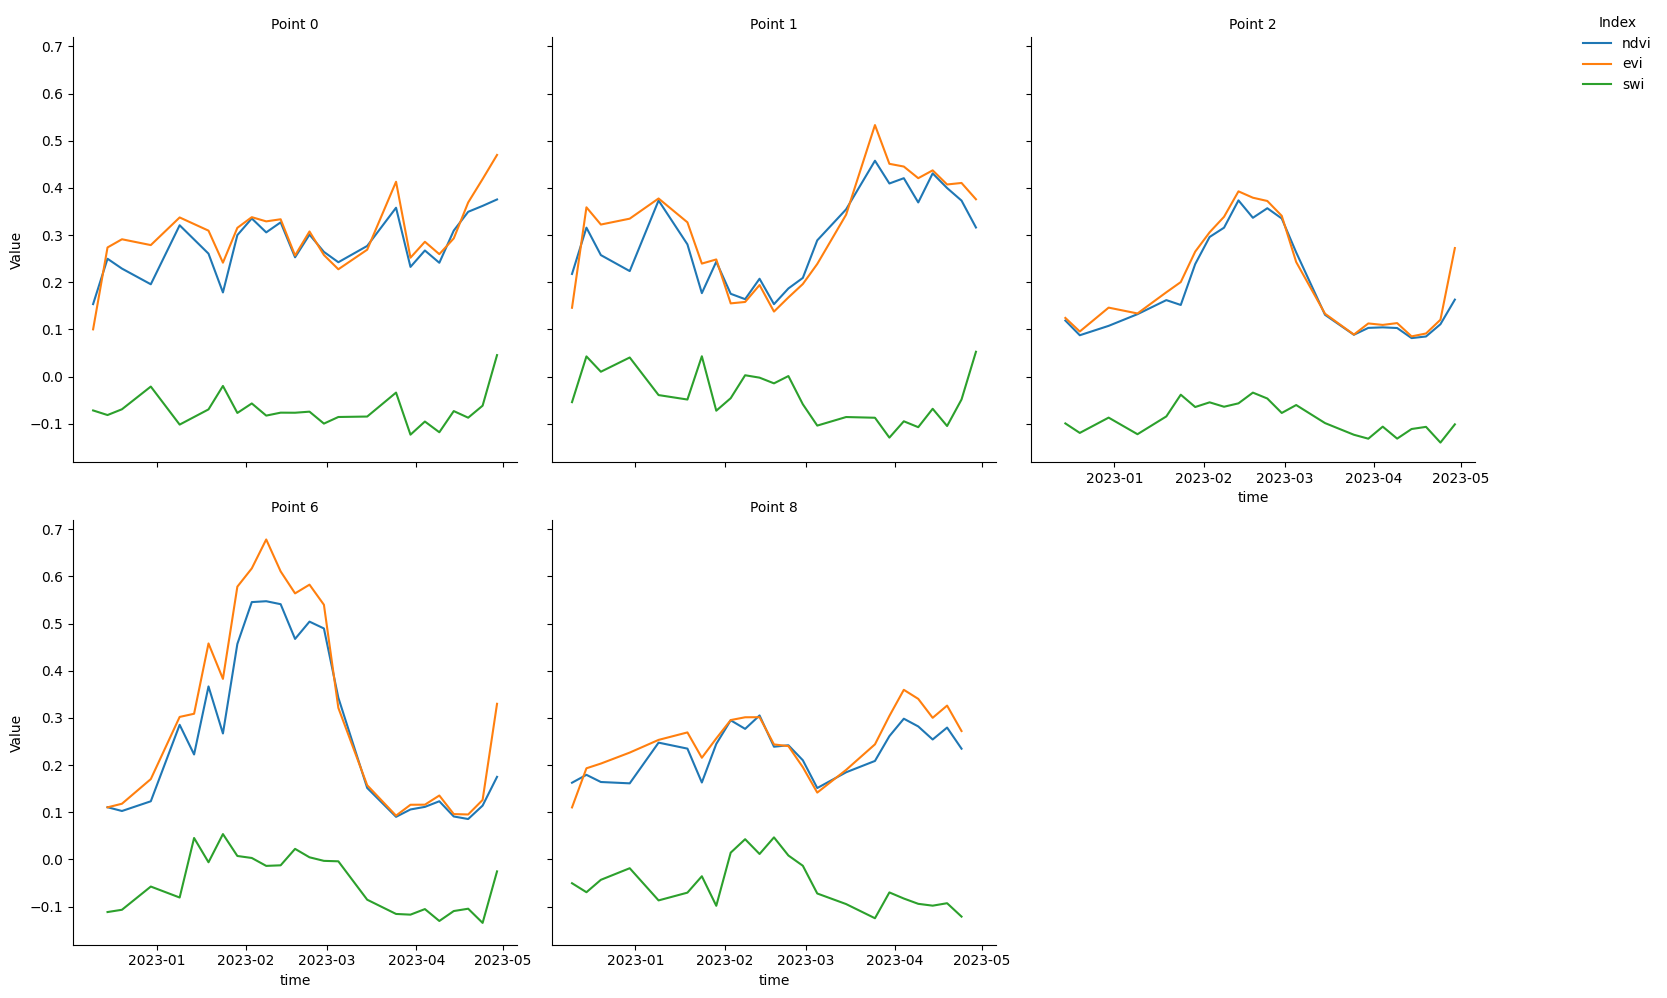

In [113]:
sel_pid = [0, 1, 2, 6, 8] # select a few points to plot
fig = sns.relplot(xx_df2.loc[xx_df2.pid.isin(sel_pid),:], x = 'time', y = 'Value', hue = 'Index', kind= 'line', col = 'pid', col_wrap=3)
fig.set_titles(col_template = 'Point '+'{col_name}')
sns.move_legend(fig, loc = 'upper left', bbox_to_anchor = (1,1))
fig.savefig('/home/jovyan/phenology_ts.png')